    Настало время потренироваться в очистке данных! В этот раз тема особенно важная — поговорим о диабете.

Вам предоставлен набор данных, первоначально полученный в Национальном институте диабета, болезней органов пищеварения и почек. 

Этот набор данных создан для того, чтобы на основе определённых диагностических измерений предсказать, есть ли у пациента диабет. 

На выбор этих экземпляров из более крупной базы данных было наложено несколько ограничений. В частности, все пациенты здесь — женщины не моложе 21 года индейского происхождения Пима.

Прочитаем наши данные и выведем первые пять строк таблицы:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

diabetes = pd.read_csv('data/diabetes_data.csv')
diabetes1 = diabetes.copy()


diabetes['Pregnancies'].max()

dupl_columns = list(diabetes.columns)
mask = diabetes.duplicated(subset=dupl_columns)
diabet_duplicates = diabetes[mask]
print(f'Число найденных дубликатов: {diabet_duplicates.shape[0]}')

sber_dedupped = diabetes.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

# diabetes.info()
status = diabetes['Outcome']

for i in range(len(status)):
    if status[i] == 1:
        status[i] = 'Yes'
    elif status[i] == 0:
        status[i] = 'Not!'

diabetes = diabetes.replace(0, np.nan)

nan_ratio = diabetes['Insulin'].isna().sum() / len(diabetes['Insulin'])
print(f"Доля NaN в стобце Insulin: {nan_ratio}")

del diabetes['Gender']

for col in diabetes.columns:
    # определяем долю NaN в столбце
    nan_ratios = diabetes[col].isna().sum() / len(diabetes[col])
    # сравниваем долю NaN c целевым порогом 
    if nan_ratios > 0.3:
        # удаляем признак в котором Nan выше порога
        diabetes=diabetes.drop(col, axis=1) 
        
drop_diabetes = diabetes.copy()
drop_diabetes = diabetes.dropna(thresh=len(drop_diabetes.columns)-2)

display(drop_diabetes)

Число найденных дубликатов: 10
Результирующее число записей: 768
Доля NaN в стобце Insulin: 0.4884318766066838


C:\Users\Денчік\AppData\Local\Temp\ipykernel_34232\1415740517.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  status[i] = 'Not!'


,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,98.0,58.0,33.0,34.0,0.430,43,Not!
1,2.0,112.0,75.0,32.0,35.7,0.148,21,Not!
2,2.0,108.0,64.0,NaN,30.8,0.158,21,Not!
3,8.0,107.0,80.0,NaN,24.6,0.856,34,Not!
4,7.0,136.0,90.0,NaN,29.9,0.210,50,Not!
...,...,...,...,...,...,...,...,...
772,7.0,136.0,90.0,NaN,29.9,0.210,50,Not!
773,6.0,103.0,72.0,32.0,37.7,0.324,55,Not!
774,1.0,71.0,48.0,18.0,20.4,0.323,22,Not!
776,4.0,154.0,72.0,29.0,31.3,0.338,37,Not!


В оставшихся записях замените пропуски на медиану. Чему равно среднее значение в столбце SkinThickness? Ответ округлите до десятых.

In [3]:
#создаем копию исходной таблицы
fill_data = drop_diabetes.copy()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'Pregnancies': fill_data['Pregnancies'].median(),
    'Glucose': fill_data['Glucose'].median(),
    'BloodPressure': fill_data['BloodPressure'].median(),
    'SkinThickness': fill_data['SkinThickness'].median(),
    'BMI': fill_data['BMI'].median(),
    'DiabetesPedigreeFunction': fill_data['DiabetesPedigreeFunction'].median(),
    'Age': fill_data['Age'].median(),
}
#заполняем пропуски в соответствии с заявленным словарем
fill_data = fill_data.fillna(values)
#выводим результирующую долю пропусков
fill_data.isnull().mean()

fill_data['SkinThickness'].mean()

29.107752956636006

Сколько выбросов найдёт классический метод межквартильного размаха в признаке SkinThickness?

In [4]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(fill_data, 'SkinThickness')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')  

Число выбросов по методу Тьюки: 87
Результирующее число записей: 674


Сколько выбросов найдёт классический метод z-отклонения в признаке SkinThickness?

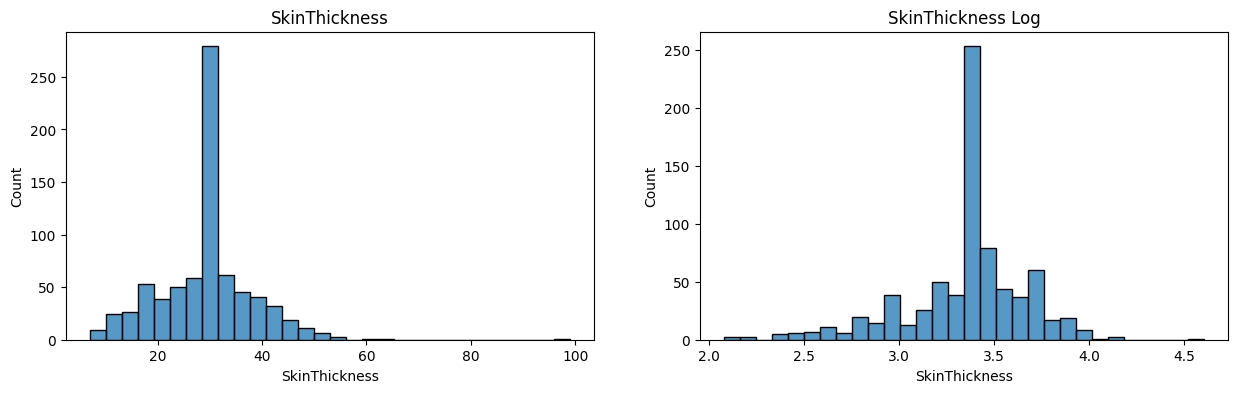

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(fill_data['SkinThickness'], bins=30, ax=axes[0])
histplot.set_title('SkinThickness');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(fill_data['SkinThickness'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('SkinThickness Log');

In [6]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score(fill_data, 'SkinThickness', log_scale=False)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 4
Результирующее число записей: 757


На приведённой гистограмме показано распределение признака DiabetesPedigreeFunction. Такой вид распределения очень похож на логнормальный, и он заставляет задуматься о логарифмировании признака. Найдите сначала число выбросов в признаке DiabetesPedigreeFunction с помощью классического метода межквартильного размаха.

Затем найдите число выбросов в этом же признаке в логарифмическом масштабе (при логарифмировании единицу прибавлять не нужно!). Какова разница между двумя этими числами (вычтите из первого второе)?

In [7]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(fill_data, 'DiabetesPedigreeFunction')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}') 

Число выбросов по методу Тьюки: 29
Результирующее число записей: 732


In [8]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score(fill_data, 'DiabetesPedigreeFunction', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 0
Результирующее число записей: 761


Pregnancies — количество беременностей.

Glucose — концентрация глюкозы в плазме через два часа при пероральном тесте на толерантность к глюкозе.

BloodPressure — диастолическое артериальное давление (мм рт. ст.).

SkinThickness — толщина кожной складки трицепса (мм).

Insulin — двухчасовой сывороточный инсулин (ме Ед/мл).

BMI — индекс массы тела

DiabetesPedigreeFunction — функция родословной диабета (чем она выше, тем выше шанс наследственной заболеваемости).

Age — возраст.

Outcome — наличие диабета (0 — нет, 1 — да).

    Предварительно вы можете провести небольшой разведывательный анализ: посмотреть на распределения признаков и оценить их взаимосвязь с признаком наличия диабета.

Text(0, 0.5, 'Кровяное давление')

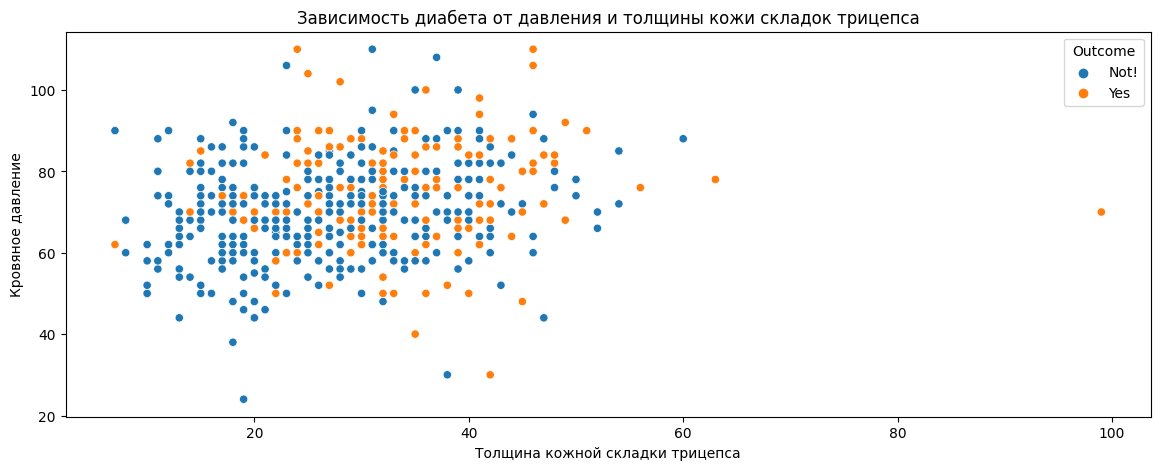

In [9]:
fig = plt.figure(figsize=(14, 5))

scatterplot = sns.scatterplot(
    data=diabetes,
    x='SkinThickness',
    y='BloodPressure',
    hue='Outcome'
);

plt.title('Зависимость диабета от давления и толщины кожи складок трицепса')
plt.xlabel('Толщина кожной складки трицепса')
plt.ylabel('Кровяное давление')

Text(0, 0.5, 'Количество беременностей')

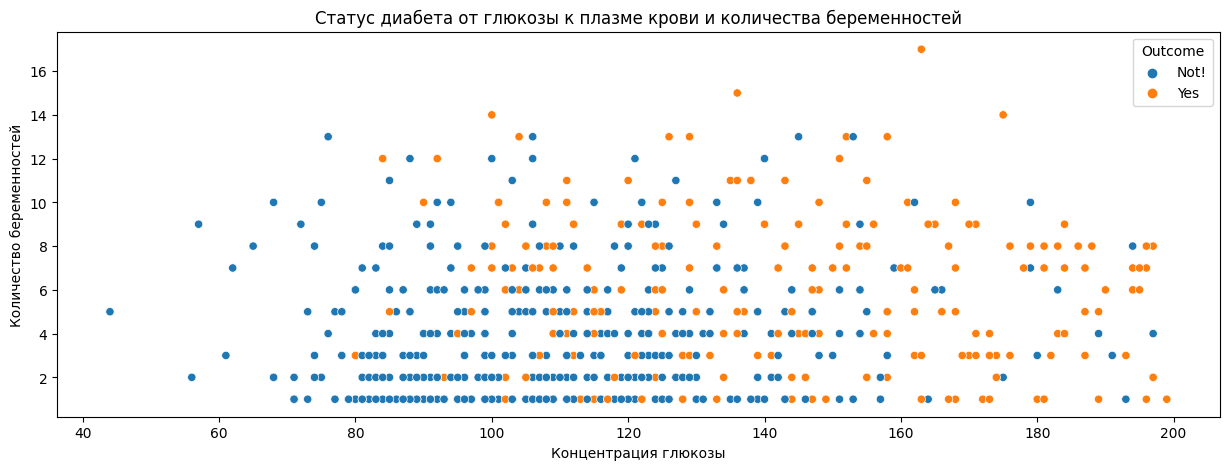

In [10]:
fig = plt.figure(figsize=(15, 5))

scatterplot = sns.scatterplot(
    data=diabetes,
    x='Glucose',
    y='Pregnancies',
    hue='Outcome'
);

plt.title('Статус диабета от глюкозы к плазме крови и количества беременностей')
plt.xlabel('Концентрация глюкозы')
plt.ylabel('Количество беременностей')

Text(0, 0.5, 'Возраст')

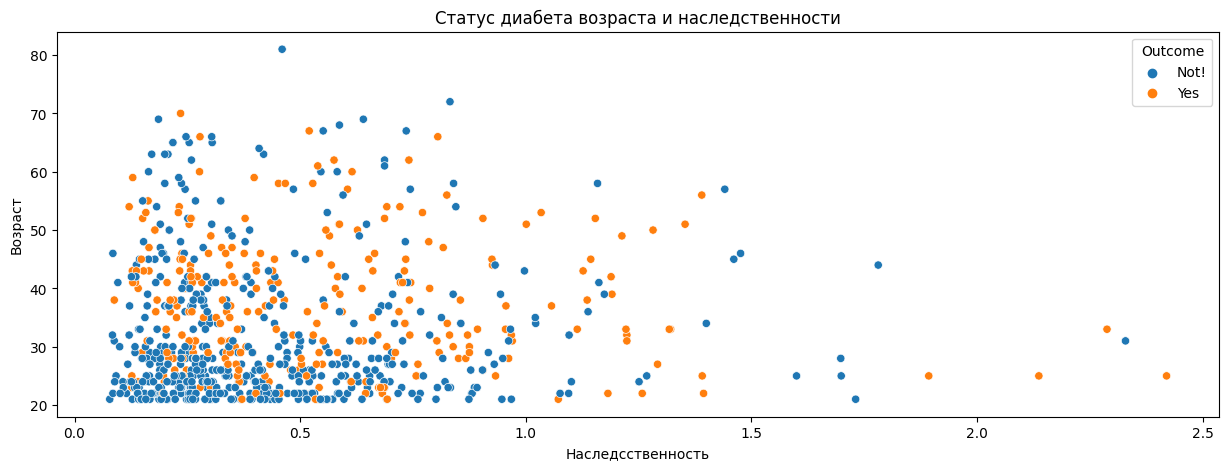

In [11]:
fig = plt.figure(figsize=(15, 5))

scatterplot = sns.scatterplot(
    data=diabetes,
    x='DiabetesPedigreeFunction',
    y='Age',
    hue='Outcome'
);

plt.title('Статус диабета возраста и наследственности')
plt.xlabel('Наследсственность')
plt.ylabel('Возраст')

In [19]:
tsum = pd.read_excel('data/Data_TSUM_clean.xlsx')
tsum2 = pd.read_excel('data/Data_TSUM_clean2.xlsx')
display(tsum)


,brand,Category,producerid,producercolor,price
0,Valentino,Shoes,aaaaa111111,black,167
1,Valentino,Shoes,aaaaa111112,black,188
2,Valentino,Shoes,aaaaa111113,black,184
3,Valentino,Shoes,aaaaa111114,black,196
4,Valentino,Shoes,aaaaa111115,black,250
...,...,...,...,...,...
70,Stone Island,Bags,sssss111131,red,164
71,Stone Island,Bags,sssss111132,red,158
72,Stone Island,Bags,sssss111133,red,194
73,Stone Island,Bags,sssss111134,red,256


In [21]:
display(tsum2)
price1 = tsum2['current price']




,brand,Category,itemid,colorid,current price
0,Valentino,Shoes,aaaaa111111,black,247
1,Valentino,Shoes,aaaaa111112,black,161
2,Valentino,Shoes,aaaaa111113,black,234
3,Valentino,Shoes,aaaaa111114,black,167
4,Valentino,Shoes,aaaaa111115,black,153
...,...,...,...,...,...
70,Stone Island,Bags,sssss111131,red,165
71,Stone Island,Bags,sssss111132,red,196
72,Stone Island,Bags,sssss111133,red,236
73,Stone Island,Bags,sssss111134,red,222


0     247
1     161
2     234
3     167
4     153
     ... 
70    165
71    196
72    236
73    222
74    275
Name: current price, Length: 75, dtype: int64


In [45]:
tsum3 = pd.concat([tsum, price1], axis=1)



tsum3['difference'] = tsum3['current price'] - tsum3['price']
display(tsum3)

tsum3['difference'].max()

,brand,Category,producerid,producercolor,price,current price,difference
0,Valentino,Shoes,aaaaa111111,black,167,247,80
1,Valentino,Shoes,aaaaa111112,black,188,161,-27
2,Valentino,Shoes,aaaaa111113,black,184,234,50
3,Valentino,Shoes,aaaaa111114,black,196,167,-29
4,Valentino,Shoes,aaaaa111115,black,250,153,-97
...,...,...,...,...,...,...,...
70,Stone Island,Bags,sssss111131,red,164,165,1
71,Stone Island,Bags,sssss111132,red,158,196,38
72,Stone Island,Bags,sssss111133,red,194,236,42
73,Stone Island,Bags,sssss111134,red,256,222,-34


123

In [44]:
tsum3['difference'].min()

-117

In [46]:
tsum3['difference'].mean()

2.6

In [47]:
tsum3['difference'].mode()

0    13
Name: difference, dtype: int64

In [51]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score(tsum3, 'difference')
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')


Число выбросов по методу z-отклонения: 0
Результирующее число записей: 75


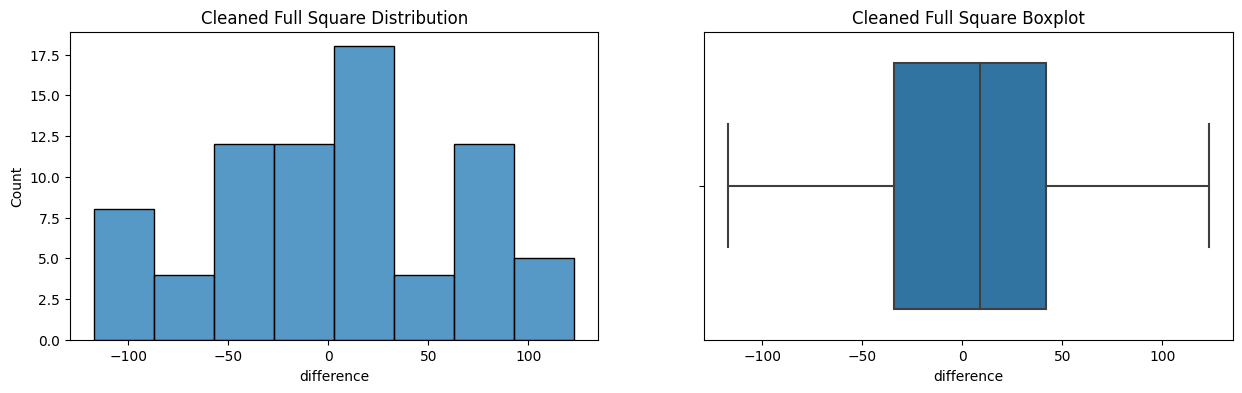

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='difference', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='difference', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

In [ ]:
file_path = "data\Data_TSUM_final.xlsx"


tsum3.to_excel(file_path, index=False)